In [1]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util, util

In [2]:
# Parameters
system_name = "J1515+1511"
filter = "F160W"
r1 = 3.7
dx_outer = -0.3
dy_outer = 0.6
dx_center = 0.
dy_center = 0.1
x1 = 41
y1 = 59
x2 = 56
y2 = 45
x3 = 63
y3 = 45
use_center_mask = False

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_13023/1421529458.py:20: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


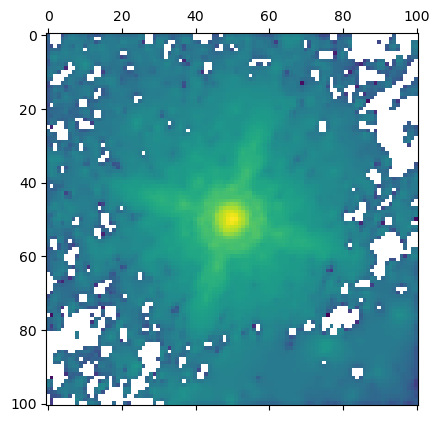

In [3]:
# load PSF data
psf_file = 'outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

variance = np.loadtxt('psf_variance.txt')

var_array = np.array(variance)

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              'psf_variance_map': var_array}
psf_class = PSF(**kwargs_psf)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [4]:
# Open the FITS file and extract the header
filename = f'{system_name}_{filter}_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.08  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_13023/323105573.py:7: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


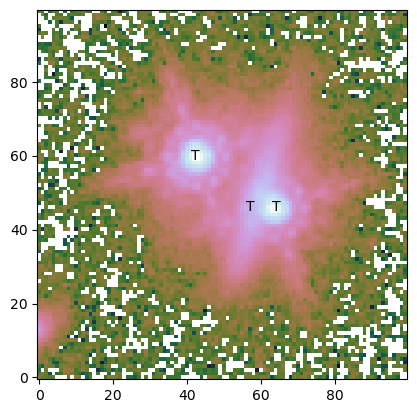

In [5]:
# display science image and obtain coordinates of point source and lens centers

plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')
plt.show()

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

In [6]:
# set up data class
kwargs_data = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

Initial guess for theta_E: 1.0430723848324237


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_13023/3972700343.py:44: RuntimeWarning: divide by zero encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_13023/3972700343.py:44: RuntimeWarning: invalid value encountered in log10
  image = np.log10(kwargs_data["image_data"] * mask_img)


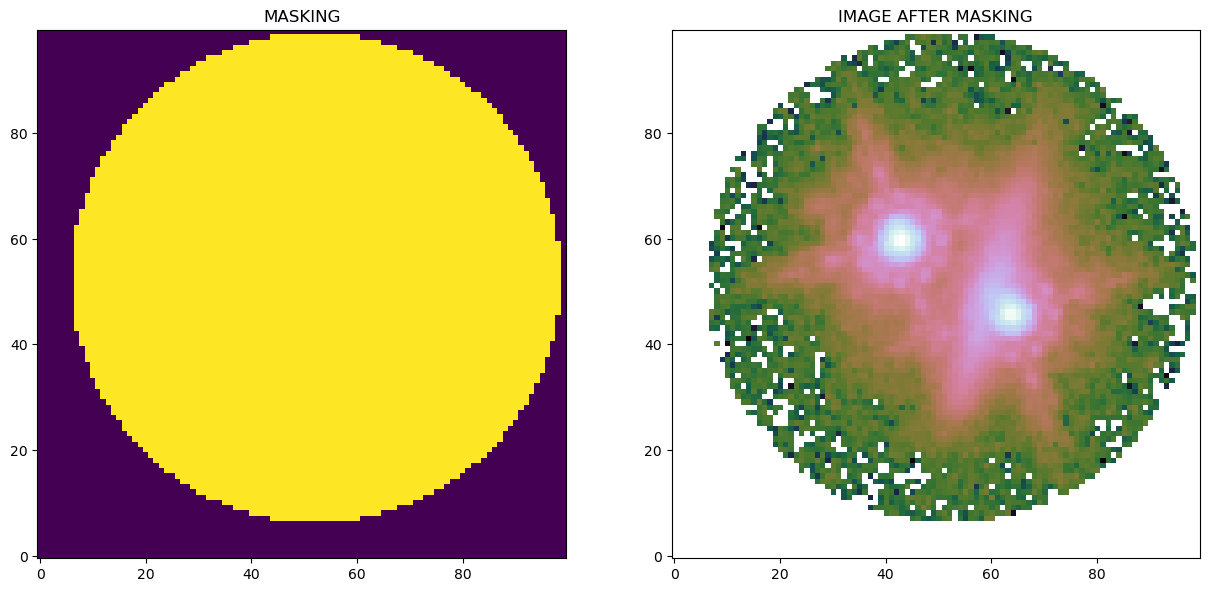

In [7]:
# create a central mask

num_pix = len(kwargs_data["image_data"])

r1 = r1 # arcsecond
lens_center_ra = lens_center_x
lens_center_dec = lens_center_y

mask_outer_1 = mask_util.mask_center_2d(  # Outer mask
    lens_center_ra + dx_outer,
    lens_center_dec + dy_outer,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_1 = (1 - mask_outer_1)

mask1 = mask_1

if use_center_mask == True:
    mask_ext_6 = mask_util.mask_ellipse(    # Central Mask
        util.image2array(x_coords),
        util.image2array(y_coords),
        lens_center_ra + dx_center,
        lens_center_dec + dy_center,
        0.6,
        0.6,
        0,
    )

    mask_3 = (1 - mask_ext_6) 
    mask1 = mask_1  * mask_3

mask1[mask1 >= 1] = 1

mask1[mask1 < 0] = 0


mask_img = mask1.reshape(num_pix, num_pix)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))


image = np.log10(kwargs_data["image_data"] * mask_img)


plt.sca(axs[0])
plt.imshow(mask_img, origin="lower")
plt.title("MASKING")


plt.sca(axs[1])
plt.imshow(image, origin="lower", cmap="cubehelix")
plt.title("IMAGE AFTER MASKING")
plt.show()

In [8]:
# model parameters
lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

In [9]:
# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               #'source_light_model_list': source_model_list
                               }

kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              #'joint_source_with_point_source': [[0, 0]],
                              'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]]
                              }

kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask_img],
                      #'image_position_uncertainty': 0.004,
                        #'check_matched_source_position': True,
                        'source_position_likelihood': True,
                              'source_position_tolerance': 0.001
                              }


image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


Computing the PSO ...


100%|██████████| 100/100 [04:12<00:00,  2.52s/it]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:224: RuntimeWarning: invalid value encountered in log10
  np.log10(self._mode

Max iteration reached! Stopping.
-1.601966922192584 reduced X^2 of best position
-5362.584272039675 log likelihood
6695.0 effective number of data points
[{'theta_E': np.float64(0.8502245059181143), 'gamma': 2, 'e1': np.float64(-0.1536196809549309), 'e2': np.float64(0.14860232904299858), 'center_x': np.float64(8.801316100748583), 'center_y': np.float64(-0.1039666012474375)}, {'gamma1': np.float64(0.02071248749045659), 'gamma2': np.float64(-0.10294034389546558), 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': np.float64(0.3714795271263022), 'n_sersic': np.float64(1.3473540712783525), 'e1': np.float64(-0.499992218149239), 'e2': np.float64(0.36257500621110955), 'center_x': np.float64(8.801316100748583), 'center_y': np.float64(-0.1039666012474375)}, {'amp': 1, 'R_sersic': np.float64(1.3490814064365964), 'n_sersic': np.float64(5.024687724867308), 'e1': np.float64(0.15937782361938907), 'e2': np.float64(-0.0256911471584844), 'center_x': np.float64(8.80131610074858

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_13023/3898881816.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


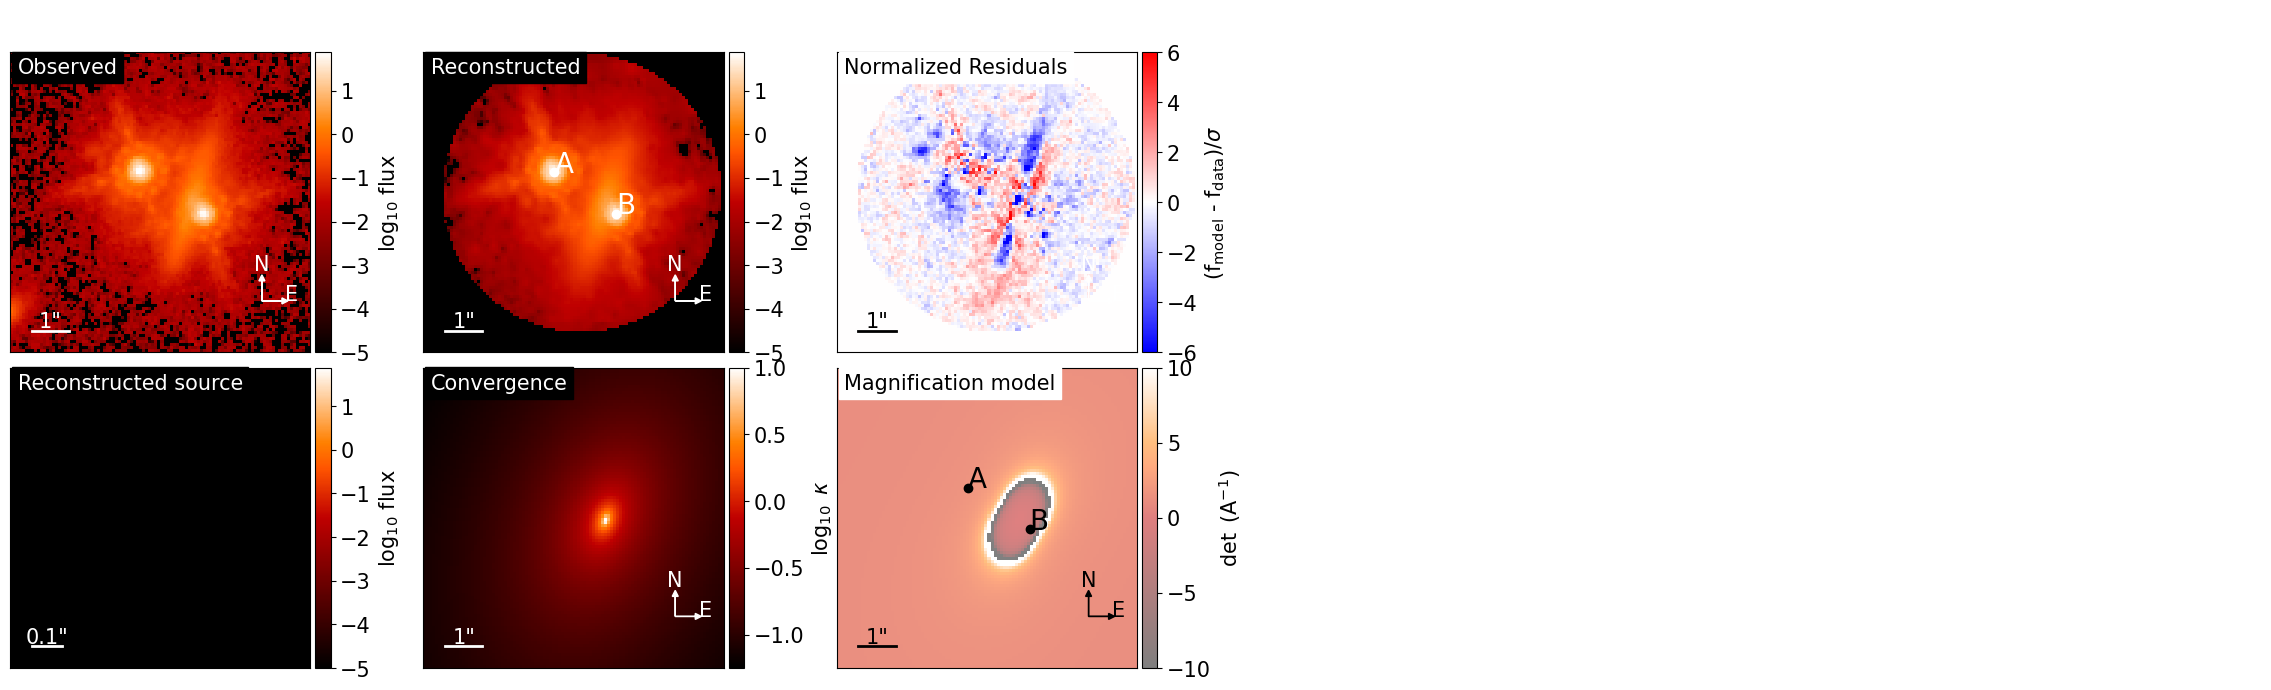

In [10]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': .0, 'e2': .0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0.15, 'e2': -.39, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'R_sersic': 3., 'n_sersic': 4., 'e1': 0., 'e2': .0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'amp': 10}
                          ]
kwargs_source_init = [{'R_sersic': 0.1, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .1, 'e2': .1, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': 0.02, 'gamma2': 0.02, 'ra_0': 1, 'dec_0': 1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'amp': 2},]
kwargs_source_sigma = [{'R_sersic': .05, 'n_sersic': .5, 'e1': 0.5, 'e2': 0.5, 'center_x': .5, 'center_y': .5}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.25, 'e2': -0.25, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3, 'ra_0': -10, 'dec_0': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': -0.5, 'e2': - 0.5, 'center_x': -10, 'center_y': -10},
                           {'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': -0.5, 'e2': - 0.5, 'center_x': -10, 'center_y': -10},
                           {'amp': -30}]
kwargs_lower_source = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.25, 'e2': -0.25, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3, 'ra_0': 10, 'dec_0': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.5, 'e2': 0.5, 'center_x': lens_center_x + 1, 'center_y': 10},
                           {'R_sersic': 10, 'n_sersic': 6., 'e1': 0.5, 'e2': 0.5, 'center_x': lens_center_x + 1, 'center_y': 10},
                           {'amp': 30},]
kwargs_upper_source = [{'R_sersic': .8, 'n_sersic': 2, 'e1': 0.25, 'e2': 0.25, 'center_x': lens_center_x + 1, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 #'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = True)


fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"], arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()